# Modeling a serial dilution experiment on different dispensing hardware

A recent paper by Elkins et al. [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013], a large discrepany was observed in IC50 assay values in which either a LabCyte Echo acoustic dispensing unit or a Tecan Genesis liquid handling workstation were used in performing the assays.  This discrepancy may be due to any number of factors, but one of the main features of the Echo is its direct dispensing technology that allows a dilution series over several orders of magnitude in concetration to be created *directly* without the need for serial dilution.  Could the observed discrepancy be explained by the difference in the accuracy with which a serial dilution can be created by these two technologies?  A little modeling of the experiment can quickly find out!

In [1]:
import numpy
from pylab import *
%matplotlib inline
from matplotlib import pyplot

## Dispensing by BioMek NX/FX liquid-handling robot

Let's model how a liquid-handling robot creates a dilution series for a compound via serial dilution.  An ideal dilution series has no error in transferred volumes and ensures complete mixing between dilution steps.

In [2]:
def dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions):
    import numpy
    from numpy.random import normal
    ideal_concentrations = numpy.zeros([ndilutions], numpy.float64)
    ideal_volumes = numpy.zeros([ndilutions], numpy.float64)
    ideal_concentrations[0] = C0
    ideal_volumes[0] = V0
    for n in range(1,ndilutions):
        ideal_concentrations[n] = ideal_concentrations[n-1] * Vtransfer / (Vtransfer + Vbuffer)
        ideal_volumes[n] = Vtransfer + Vbuffer
        ideal_volumes[n-1] -= Vtransfer
    ideal_volumes[ndilutions-1] -= Vtransfer
    return [ideal_volumes, ideal_concentrations]

Let's consider a 12-point 2x dilution series, where we start with 10 mM compound stocks.

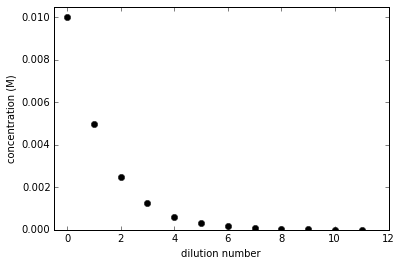

In [3]:
ndilutions = 12 # number of points in dilution series (including original concentration)
V0 = 100e-6 # 100 uL final volume in each well
#C0 = 10e-3 * 0.05 # 10 mM initial DMSO stock diluted to 5% DMSO
C0 = 10e-3 # 10 mM initial DMSO stock
Vtransfer = 50e-6 # 50 uL transfer from previous dilution or stock
Vbuffer = 50e-6 # 50 uL buffer
[ideal_volumes, ideal_concentrations] = dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions)

# Plot ideal concentrations.
clf()
plot(range(ndilutions), ideal_concentrations, 'ko');
xlabel('dilution number');
ylabel('concentration (M)');
axis([-0.5, ndilutions, 0.0, C0*1.05]);

Real liquid-handling robots can't transfer the specified volume exactly.  Each transfer operation has some inaccuracy (modeled as a constant bias factor for all dispensing operations) and imprecision (random error associated with each volume transfer).  We'll ignore other contributions to error, such as compound stickiness, insolubility, etc.

In [4]:
def biomek_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, inaccuracy, imprecision):
    from numpy.random import normal
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    bias = inaccuracy * normal()
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+bias) + imprecision*normal())
        Vbuffer_actual = Vbuffer * ((1+bias) + imprecision*normal())
        actual_concentrations[n] = actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)
        actual_volumes[n] = Vtransfer_actual + Vbuffer_actual
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+bias) + imprecision*normal())
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    return [actual_volumes, actual_concentrations]

Suppose we generate this dilution series using a Beckman Biomek robot (3% inaccuracy, 5% imprecision at 50 uL transfer volumes):

In [5]:
# Biomek NX or FX specs
inaccuracy = 0.03 # 3% inaccuracy
imprecision = 0.05 # 5% imprecision
[actual_volumes, actual_concentrations] = biomek_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, inaccuracy, imprecision)
print actual_volumes
print actual_concentrations

[  5.06017900e-05   5.22597663e-05   4.30819468e-05   5.38944539e-05
   5.75358431e-05   4.50306505e-05   5.15412676e-05   4.83345027e-05
   4.63239090e-05   5.54295651e-05   4.67576706e-05   4.67840435e-05]
[  1.00000000e-02   4.96338384e-03   2.39541200e-03   1.24183423e-03
   6.06842313e-04   3.11361762e-04   1.54203303e-04   7.64418242e-05
   4.04128065e-05   1.92082640e-05   9.47519062e-06   4.88426383e-06]


Let's plot the relative errors in concentration, volume, and total quantity of compound per well generated in this particular replicate of the dilution series:

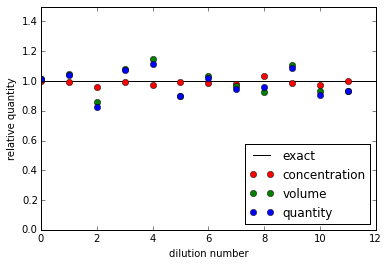

In [6]:
clf();
hold(True);
plot([0, ndilutions], [1, 1], 'k-');
plot(range(ndilutions), actual_concentrations / ideal_concentrations, 'ro', range(ndilutions), actual_volumes / ideal_volumes, 'go', range(ndilutions), (actual_volumes*actual_concentrations)/(ideal_volumes*ideal_concentrations), 'bo');
legend(['exact', 'concentration', 'volume', 'quantity'], loc='lower right');
axis([0, ndilutions, 0, 1.5]);
ylabel('relative quantity');
xlabel('dilution number');

If we repeat the experiment many times, we can estimate the CV for each dilution number.

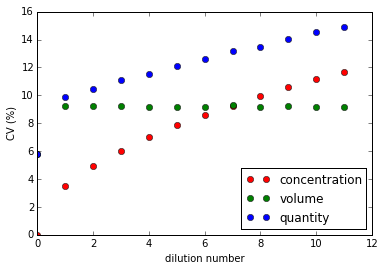

In [7]:
nreplicates = 10000
actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = biomek_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, inaccuracy, imprecision)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

# Plot CVs
clf()
x = numpy.arange(ndilutions)
plot(x, concentrations_cv*100, 'ro', x, volumes_cv*100, 'go', x, quantity_cv*100, 'bo');
xlabel('dilution number');
ylabel('CV (%)');
legend(['concentration', 'volume', 'quantity'], loc='lower right');

If we now dispense 2 uL of diluted compound into an assay plate well into which 10 uL of enzyme mix has been dispensed, there is additional error since the imprecision at this volume is higher.

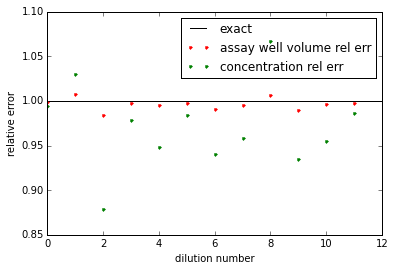

In [8]:
compound_volume = 2.0e-6 # 2 uL 
mix_volume = 10.0e-6 # 10 uL
small_volume_inaccuracy = 0.03 # Biomek, ~1 uL dispense
small_volume_imprecision = 0.07 # Biomek, ~1 uL dispense
def biomek_dispense(compound_volume, mix_volume, compound_concentrations, small_volume_inaccuracy, small_volume_imprecision):
    from numpy.random import normal
    assay_volume = numpy.zeros([ndilutions], numpy.float64)
    assay_compound_concentration = numpy.zeros([ndilutions], numpy.float64)
    bias = inaccuracy * normal()
    for i in range(ndilutions):
        compound_volume_dispensed = compound_volume * ((1+bias) + imprecision*normal())
        mix_volume_dispensed = mix_volume
        assay_volume[i] = compound_volume_dispensed + mix_volume_dispensed
        assay_compound_concentration[i] = compound_concentrations[i] * compound_volume_dispensed / assay_volume[i]

    return [assay_volume, assay_compound_concentration]

[assay_volumes, assay_compound_concentrations] = biomek_dispense(compound_volume, mix_volume, actual_concentrations, inaccuracy, imprecision)

pyplot.clf()
pyplot.plot([0,ndilutions], [1, 1], 'k-', range(ndilutions), assay_volumes / (compound_volume+mix_volume), 'r.', range(ndilutions), assay_compound_concentrations / (ideal_concentrations*compound_volume/(compound_volume+mix_volume)), 'g.')
pyplot.legend(['exact', 'assay well volume rel err', 'concentration rel err'], loc='upper right')
pyplot.xlabel('dilution number')
pyplot.ylabel('relative error')
pyplot.show()

Let's suppose the 10 uL of assay mix in each well was dispensed completely accurately, and contains exact concentrations of enzyme and substrate.  We presume inhibition is measured by an exact read of the reaction V0/Vmax.  The IC50 would be the interpolated point at which V0/Vmax drops to 0.5, as determined from a fit of the competitive inhibition equations to the observed V0/Vmax for the dilution series, using the *ideal* dilution series concentrations in the fit.  Let's assume the true Ki is 10 nM, with Km of 1.71 uM (the Km for ATP by EphB4).  Note that we're assuming that EphB4 obeys Michaelis-Menten kinetics here, and that V0/Vmax is what is measured.

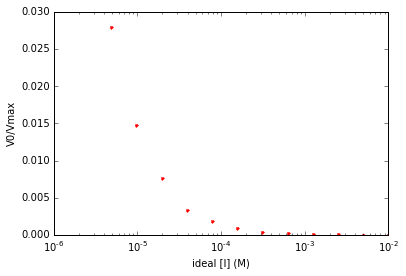

In [9]:
def competitive_inhibition(substrate_concentration, inhibitor_concentration, enzyme_concentration, Ki, Km):
    V0_over_Vmax = substrate_concentration / (Km*(1 + inhibitor_concentration/Ki) + substrate_concentration)
    return V0_over_Vmax

substrate_concentration = 4e-6 # 4 mM ATP
enzyme_concentration = 6e-6 # 0.25 ng of ~42.4 kDa enzyme = ~6 uM
true_Ki = 10e-9 # 10 nM
Km = 1.71e-6 # ATP Km from http://www.proqinase.com/kinase-database/pdfs/2843.pdf

activity = numpy.zeros([ndilutions], numpy.float64)
for i in range(ndilutions):
    activity[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

pyplot.clf()
pyplot.semilogx(ideal_concentrations, activity, 'r.')
pyplot.xlabel('ideal [I] (M)')
pyplot.ylabel('V0/Vmax')
pyplot.show()

What does this look like if we run many assay replicates?

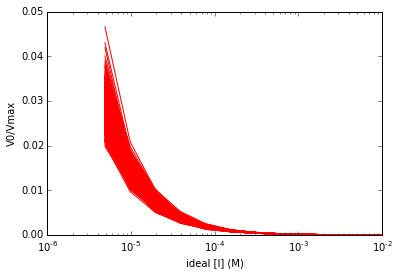

In [10]:
nreplicates = 1000
activity = numpy.zeros([nreplicates,ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [actual_volumes, actual_concentrations] = biomek_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, inaccuracy, imprecision)
    [assay_volumes, assay_compound_concentrations] = biomek_dispense(compound_volume, mix_volume, actual_concentrations, small_volume_inaccuracy, small_volume_imprecision)
    for i in range(ndilutions):
        activity[replicate,i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

pyplot.clf()
pyplot.semilogx(ideal_concentrations, activity.transpose(), 'r-')
pyplot.xlabel('ideal [I] (M)')
pyplot.ylabel('V0/Vmax')
pyplot.show()

It's not hard to see that the IC50 will vary over a large range!  Let's fit the IC50s to see.

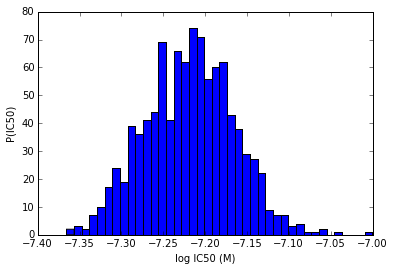

In [11]:
def fit_ic50(inhibitor_concentrations, activities):
    import numpy, scipy
    def objective(inhibitor_concentrations, Ki):
        activities = numpy.zeros([ndilutions], numpy.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, inhibitor_concentrations[i], enzyme_concentration, Ki, Km)
        return activities
            
    Ki_guess = true_Ki
    import scipy.optimize
    [popt, pcov] = scipy.optimize.curve_fit(objective, inhibitor_concentrations, activities, p0=[Ki_guess])
    
    return popt[0]

IC50s_tips = numpy.zeros([nreplicates], numpy.float64)
for replicate in range(nreplicates):
    IC50s_tips[replicate] = fit_ic50(ideal_concentrations, activity[replicate,:])

clf()
nhist = 40
hist(numpy.log10(IC50s_tips), nhist);
xlabel('log IC50 (M)');
ylabel('P(IC50)');

The error won't be uniform across the whole Ki range, however.  Let's characterize the standard error as a function of Ki.

In [12]:
def biomek_IC50_error(true_Ki):
    nreplicates = 1000
    IC50s = numpy.zeros([nreplicates], numpy.float64)
    for replicate in range(nreplicates):
        [actual_volumes, actual_concentrations] = biomek_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, inaccuracy, imprecision)
        [assay_volumes, assay_compound_concentrations] = biomek_dispense(compound_volume, mix_volume, actual_concentrations, small_volume_inaccuracy, small_volume_imprecision)
        activities = numpy.zeros([ndilutions], numpy.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(ideal_concentrations, activities)
    return IC50s.std()

Kis = numpy.array([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3])
nKis = len(Kis)
biomek_errors = numpy.zeros([nKis], numpy.float64)
for (i, Ki) in enumerate(Kis):
    biomek_errors[i] = biomek_IC50_error(Ki)

biomek_relative_errors = biomek_errors / Kis
print biomek_relative_errors

[ 0.75531594  0.76528862  0.73604887  0.7281129   0.73287515  0.74295047
  0.64953354  0.49365238  0.34393926  0.24397047]


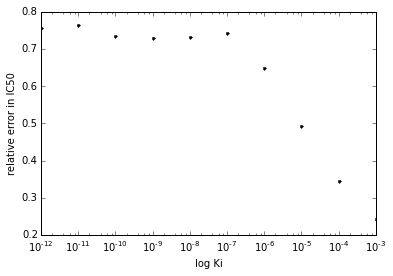

In [13]:
clf()
semilogx(Kis, biomek_relative_errors, 'k.')
xlabel('log Ki')
ylabel('relative error in IC50')

It's easier to judge the size of the error in log10 units.

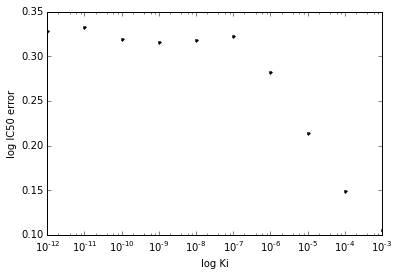

In [14]:
biomek_logIC50_errors = biomek_errors / (Kis * numpy.log(10))

clf()
semilogx(Kis, biomek_logIC50_errors, 'k.')
xlabel('log Ki')
ylabel('log IC50 error')

## Dispensing by LabCyte Echo

What about the LabCyte Echo experiments?  According to LabCyte, the Echo has an inaccuracy of 10% and a precision of 8% over the entire dispense range of 2.5 nL to 10 uL.  Let's model how it dispenses directly into the assay plate with an 9-point dilution series spanning 2.5 nL to 120 nL from 10 mM stock solution.

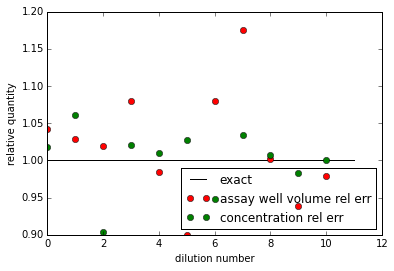

In [15]:
def echo_assay_dispense(C0, mix_volume, backfill_volume, ideal_dispense_volumes):
    inaccuracy = 0.10 # Specs from: http://www.labcyte.com/sites/default/files/support_docs/Echo%205XX%20Specifications.pdf
    imprecision = 0.08 # Specs from: http://www.labcyte.com/sites/default/files/support_docs/Echo%205XX%20Specifications.pdf
    from numpy.random import normal
    ndilutions = len(ideal_dispense_volumes)
    assay_volume = numpy.zeros([ndilutions], numpy.float64)
    assay_concentration = numpy.zeros([ndilutions], numpy.float64)
    bias = inaccuracy * normal()
    for i in range(ndilutions):
        compound_volume_intended = ideal_dispense_volumes[i]
        backfill_volume_intended = backfill_volume - compound_volume_intended
        
        compound_volume_dispensed = compound_volume_intended * ((1+bias) + imprecision*normal())
        backfill_volume_dispensed = backfill_volume_intended * ((1+bias) + imprecision*normal())
        
        assay_volume[i] = mix_volume + backfill_volume_dispensed + compound_volume_dispensed
        assay_concentration[i] = C0 * compound_volume_dispensed / assay_volume[i]

    return [assay_volume, assay_concentration]

C0 = 10e-3 # 10 mM stock solution
ideal_assay_volume = 120e-9 # 120 nL
#ideal_dispense_volumes = 2.5e-9 * numpy.array([6, 12, 18, 24, 30, 36, 42, 48]) # 9-point titration, multiples of 2.5 nL
#ideal_dispense_volumes = 2.5e-9 * numpy.array([1, 6, 12, 18, 24, 30, 36, 42, 48]) # 9-point titration, multiples of 2.5 nL
ideal_dispense_volumes = 2.5e-9 * numpy.array([4, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]) # 12-point titration, multiples of 2.5 nL
ideal_concentrations = (C0*ideal_dispense_volumes/ideal_assay_volume)
ndilutions = len(ideal_dispense_volumes)
ideal_volumes = numpy.ones([ndilutions]) * ideal_assay_volume
backfill_volume = 120e-9 # backfill with DMSO to 120 nL after dispensing compound
mix_volume = ideal_assay_volume - backfill_volume # 12 uL assay volume (minus 120 uL)
[assay_volumes, assay_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, ideal_dispense_volumes)

# Plot this realization.
clf();
plot([0,ndilutions], [1, 1], 'k-', range(ndilutions), assay_volumes/ideal_assay_volume, 'ro', range(ndilutions), assay_concentrations / ideal_concentrations, 'go');
legend(['exact', 'assay well volume rel err', 'concentration rel err'], loc='lower right');
ylabel('relative quantity');
xlabel('dilution number');

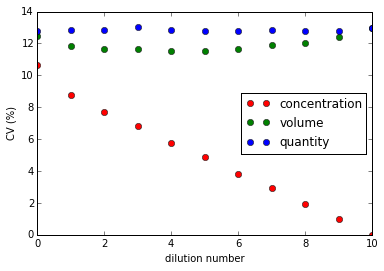

In [16]:
nreplicates = 10000
actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = echo_assay_dispense(C0, mix_volume, backfill_volume, ideal_dispense_volumes)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

# Plot CVs
clf()
x = numpy.arange(ndilutions)
plot(x, concentrations_cv*100, 'ro', x, volumes_cv*100, 'go', x, quantity_cv*100, 'bo');
xlabel('dilution number');
ylabel('CV (%)');
legend(['concentration', 'volume', 'quantity'], loc='center right');

How does a competitive inhibition look with the narrow dynamic range afforded by the LabCyte Echo?

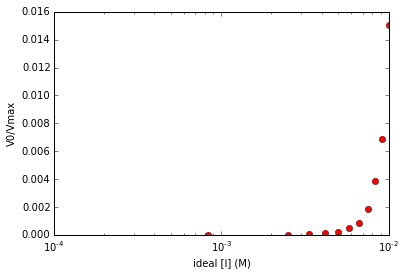

In [17]:
activity = numpy.zeros([ndilutions], numpy.float64)
for i in range(ndilutions):
    activity[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

# Plot V0/Vmax for a single realization,
clf();
semilogx(ideal_concentrations, activity, 'ro');
xlabel('ideal [I] (M)');
ylabel('V0/Vmax');

V0 only goes up to a maximum of 0.012, but we can still see some curvature that could give a decent fit to Michaelis-Menten for an IC50.  Let's try a number of replicates to see how much variation there is between measurements.

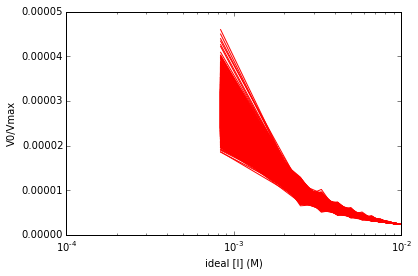

In [18]:
activity = numpy.zeros([nreplicates,ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [assay_volumes, assay_compound_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, ideal_dispense_volumes)
    for i in range(ndilutions):
        activity[replicate,i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

# Plot V0/Vmax for many measurements.
clf();
semilogx(ideal_concentrations, activity.transpose(), 'r-');
xlabel('ideal [I] (M)');
ylabel('V0/Vmax');

Transforming this into IC50s, we see there is a fair amount of error.

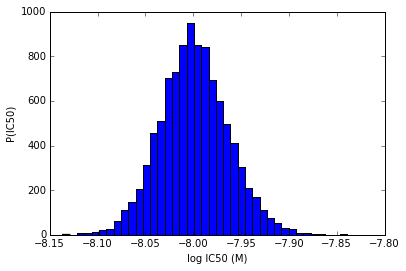

In [19]:
IC50s_echo = numpy.zeros([nreplicates], numpy.float64)
for replicate in range(nreplicates):
    IC50s_echo[replicate] = fit_ic50(ideal_concentrations, activity[replicate,:])

clf()
nhist = 40
hist(numpy.log10(IC50s_echo), nhist);
xlabel('log IC50 (M)');
ylabel('P(IC50)');

Let's characterize the error for the Echo assay as a function of Ki.

In [20]:
def echo_IC50_error(true_Ki):
    nreplicates = 1000
    IC50s = numpy.zeros([nreplicates], numpy.float64)
    for replicate in range(nreplicates):
        [assay_volumes, assay_compound_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, ideal_dispense_volumes)
        activities = numpy.zeros([ndilutions], numpy.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(ideal_concentrations, activities)
    IC50_errors = IC50s - true_Ki
    return IC50_errors.std()

Kis = numpy.array([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3])
nKis = len(Kis)
echo_errors  = numpy.zeros([nKis], numpy.float64)
for (i, Ki) in enumerate(Kis):
    echo_errors[i] = echo_IC50_error(Ki)
     
echo_relative_errors = echo_errors / Kis
print echo_relative_errors

[ 0.0864345   0.08215067  0.08022664  0.08256114  0.08217674  0.08212604
  0.0838081   0.08119633  0.05866898  0.01890122]


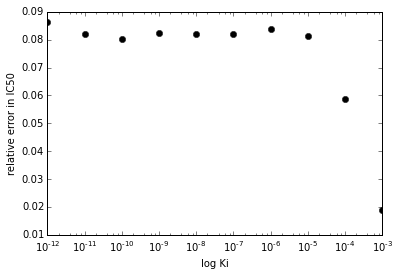

In [21]:
# Plot relative error in measured Ki values as a function of true Ki.
clf()
semilogx(Kis, echo_relative_errors, 'ko');
xlabel('log Ki');
ylabel('relative error in IC50');

## Comparison of Biomek NX vs Labcyte Echo modeled performance

What do we get when we plot the tips and Echo results against each other?

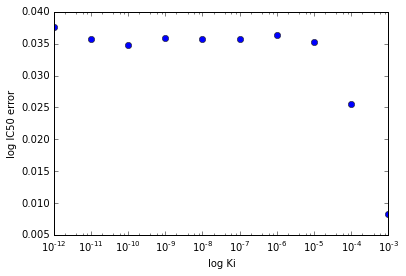

In [22]:
echo_logIC50_errors = echo_errors / (Kis * numpy.log(10))

clf()
semilogx(Kis, echo_logIC50_errors, 'o');
xlabel('log Ki');
ylabel('log IC50 error');

In [23]:
# data from Fig 1 of Fregau et al.
echo_IC50s = numpy.array([0.064, 0.486, 0.003, 0.002, 0.007, 0.003, 0.004, 0.052, 0.01362, 0.207, 0.158, 0.01164, 0.00633, 0.00358]) * 1e-6 # M
biomek_IC50s = numpy.array([0.817, 3.03, 0.146, 0.553, 0.973, 0.778, 0.445, 0.17, 0.112, 14.4, 0.25, 0.049, 0.087, 0.152]) * 1e-6 # M

# Compute errors.
ndata = len(echo_IC50s)
echo_IC50s_error = 0 * echo_IC50s
biomek_IC50s_error = 0 * biomek_IC50s
for i in range(ndata):
    echo_IC50s_error[i] = echo_IC50_error(echo_IC50s[i])
    biomek_IC50s_error[i] = biomek_IC50_error(biomek_IC50s[i])

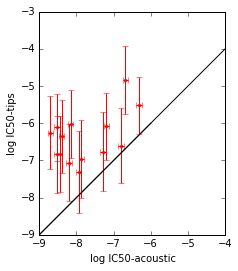

In [24]:
log10_echo_IC50s = numpy.log10(echo_IC50s)
log10_biomek_IC50s = numpy.log10(biomek_IC50s)

log10_echo_IC50s_error = echo_IC50s_error / (echo_IC50s * numpy.log(10.0))
log10_biomek_IC50s_error = biomek_IC50s_error / (biomek_IC50s * numpy.log(10.0))

# Plot comparison.
figure();
subplot(111, aspect='equal');
hold(True);
plot([-9, -4], [-9, -4], 'k-');
errorbar(log10_echo_IC50s, log10_biomek_IC50s, xerr=2*log10_echo_IC50s_error, yerr=2*log10_biomek_IC50s_error, fmt='r.')
plot([-9, -6], [-9, -6], 'k-');
#axis('equal');
xlabel('log IC50-acoustic');
ylabel('log IC50-tips');

As a result, it does not appear that the specified inaccuracy and imprecision of the Biomek NX/FX and Labcyte Echo are sufficient to explain the discrepancies observed in the assays.

## Direct dispensing with Tecan HP D300 digital dispenser

Let's see how a different direct dispensing technique---the Tecan HP D300 digitial dispenser, which uses inkjet technology---fares.

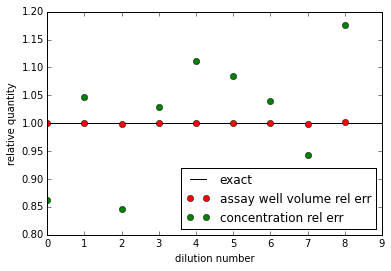

In [27]:
def d300_assay_dispense(C0, mix_volume, backfill_volume, ideal_dispense_volumes):
    inaccuracy = 0.00 # Specs from: http://www.tecan.com/platform/apps/product/index.asp?MenuID=3813&ID=8114&Menu=1&Item=21.1.12
    imprecision = 0.08 # For volumes > 100 pL; Specs from: http://www.tecan.com/platform/apps/product/index.asp?MenuID=3813&ID=8114&Menu=1&Item=21.1.12
    from numpy.random import normal
    ndilutions = len(ideal_dispense_volumes)
    assay_volume = numpy.zeros([ndilutions], numpy.float64)
    assay_compound_concentration = numpy.zeros([ndilutions], numpy.float64)
    bias = inaccuracy * normal()
    for i in range(ndilutions):
        compound_volume_intended = ideal_dispense_volumes[i]
        backfill_volume_intended = backfill_volume - compound_volume_intended
        
        compound_volume_dispensed = compound_volume_intended * ((1+bias) + imprecision*normal())
        backfill_volume_dispensed = backfill_volume_intended * ((1+bias) + imprecision*normal())
        
        assay_volume[i] = mix_volume + backfill_volume_dispensed + compound_volume_dispensed
        assay_compound_concentration[i] = C0 * compound_volume_dispensed / assay_volume[i]

    return [assay_volume, assay_compound_concentration]

C0 = 10e-3 # 10 mM stock solution
ideal_assay_volume = 12e-6 # 12 uL
ideal_dispense_volumes = 2.5e-9 * numpy.array([1, 6, 12, 18, 24, 30, 36, 42, 48]) # 9-point titration, multiples of 2.5 nL
#ideal_dispense_volumes = 2.5e-9 * numpy.array([4, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52]) # 12-point titration, multiples of 2.5 nL
ideal_concentrations = (C0*ideal_dispense_volumes/ideal_assay_volume)
ndilutions = len(ideal_dispense_volumes)
backfill_volume = 120e-9 # backfill with DMSO to 120 nL after dispensing compound
mix_volume = ideal_assay_volume - backfill_volume # 12 uL assay volume (minus 120 uL)
[assay_volumes, assay_concentrations] = d300_assay_dispense(C0, mix_volume, backfill_volume, ideal_dispense_volumes)

# Plot this realization.
clf();
plot([0,ndilutions], [1, 1], 'k-', range(ndilutions), assay_volumes/ideal_assay_volume, 'ro', range(ndilutions), assay_concentrations / ideal_concentrations, 'go');
legend(['exact', 'assay well volume rel err', 'concentration rel err'], loc='lower right');
ylabel('relative quantity');
xlabel('dilution number');

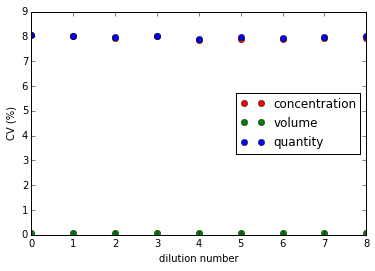

In [30]:
nreplicates = 10000
actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = d300_assay_dispense(C0, mix_volume, backfill_volume, ideal_dispense_volumes)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate
volumes_cv = (actual_volumes_n / ideal_assay_volume).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_assay_volume * ideal_concentrations)).std(0)

# Plot CVs
clf()
x = numpy.arange(ndilutions)
plot(x, concentrations_cv*100, 'ro', x, volumes_cv*100, 'go', x, quantity_cv*100, 'bo');
xlabel('dilution number');
ylabel('CV (%)');
legend(['concentration', 'volume', 'quantity'], loc='center right');

# References and further reading

* Ekins S, Olechno J, Williams AJ (2013) Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325. [doi:10.1371/journal.pone.0062325](http://dx.doi.org/10.1371/journal.pone.0062325)